# Iconography estimation
The goal is to:
- Get the iconography for each image
- Pair the hands with an iconograpy
- Create hands combination (heatmap)
- The networks will then be created in a separate notebook

## Imports

In [1]:
import os
import re
import cv2
import threading
import time
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import sys
import imageio
import random
import sqlite3
import itertools
import json
import shutil
import ntpath
import pandas as pd
import seaborn as sns
from collections import Counter

from time import sleep
from datetime import datetime
#from ipynb.fs.full.write_html import write_html, write_js
from random import randint
from random import randrange

In [2]:
import sys  
sys.path.insert(0, '../')
import KPmanager

In [3]:
from alive_progress import alive_bar
import time

In [4]:
from german_compound_splitter import comp_split
from langdetect import detect
from langdetect import detect_langs
from split_words import Splitter

In [4]:
import nltk
import requests
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.tokenize import word_tokenize

import translators as ts
ts.google 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bernasconi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/bernasconi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/bernasconi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Using state Zurich server backend.


<bound method GoogleV2.google_api of <translators.apis.GoogleV2 object at 0x7fd0da263610>>

In [5]:
IMG_PATH = "/home/bernasconi/Documents/Bernasconi/res/openpose_std_res_output_hands_CLEANED_08_2021/"
IMG_ALL_PATH = "/home/bernasconi/Documents/Bernasconi/PhD_database/biblhertz_images"
HAND_IMG_PATH = "/home/bernasconi/Documents/Bernasconi/PhD_database/output_hands_CLEANED_07_2023/"
KP_PATH = "/home/bernasconi/Documents/Bernasconi/res/output_img/"
DB_PATH = "/home/bernasconi/Documents/Bernasconi/PhD_database/biblhertz_UPDATE_08_2022.db"
CLASSIFICATION_PATH = "/home/bernasconi/Documents/Bernasconi/PhD_clusters/"

In [6]:
DB_df_ = pd.read_pickle("../DB_df_keywords_DE.pkl")

In [7]:
with open('../iconclass_dic.pkl', 'rb') as handle:
    iconclass_dic = pickle.load(handle)

In [8]:
df_hands_clusters = pd.read_csv('df_hands_clusters.csv', index_col = 0)
df_hands_clusters_flipped = pd.read_csv('df_hands_clusters_flipped.csv', index_col = 0)

In [9]:
DB_df_.head(1)

,index,object_ID,title,artist_GND,artist_name,date_begin,date_end,current_location,type,medium,dimensions,img_digital,century,id,keywords
54,54,8055384,Die Heiligen Scholastika und Benedikt empfange...,ulan500017301 & gnd123097843,Paolo de Matteis,1685.0,1725.0,Cava de' Tirreni,Gemälde,Öl,225 x 180 cm,bhim00035651,1650.0,bhim00035651_2_hand_right.jpg,"[[(11H, 1450), (71P, 119), (11I, 71), (71O, 41..."


In [10]:
df_hands_clusters.head(3)

,hands,cluster
0,bhim00037788_0_hand_right.jpg,19
1,bhim00037788_0_hand_left.jpg,6
2,bh012186_0_hand_right.jpg,35


In [11]:
df_hands_clusters_flipped.head(3)

,hands,cluster
0,bhim00037788_0_hand_right.jpg,26
1,bh012186_0_hand_right.jpg,5
2,bh013263_0_hand_right.jpg,36


## Functions definition

In [12]:
def get_tuple_count_list(_list):
    return Counter(_list).most_common()

def stop_words_removal(x, language='english'):
    english_stop_words = stopwords.words(language)
    text_wo_stop_words = [word for word in x.split() if word.lower() not in english_stop_words]
    return ' '.join(text_wo_stop_words)

def getKeyFromTitle_(title, lang='en', print_ = False):
    keywords_ = []
    icon_url = f"https://iconclass.org/api/search?q={title}&lang={lang}&page=1&sort=rank&keys=0"
    #"http://iconclass.org/rkd/0/?q="+title+"&q_s=1&fmt=json"
    try:
        r =requests.get(icon_url)
        site_json=json.loads(r.text) 
        if print_:
            print(site_json)
        try:
            for res in site_json['result']:
                keywords_.append(res)
            return keywords_
        except:
            print("no match found for "+title)
            print("error ", site_json)
    except:
        print("error with requesting url")
        
    return keywords_
 
def getKeywordsList(words_, lang='en', is_list=False, deg=3):
    
    #final_keywords = set()
    final_keywords = []
    keywords_count = []
    
    if not is_list:
        words_list = words_.split()
    else:
        words_list = words_
    
    for word in words_list:        
        word_keywords_count = [] ##V2
        #keywords = getKeyFromTitle_(word, lang)
        if word: #sometimes there is an empty word and we don't want that
            keywords = getKeyFromTitle_(word, lang)

            for key_ in keywords:
                short_key = key_[:deg] #here we take the three first descriptors (i.e. 11F in 11F112)
                word_keywords_count.append(short_key)
                keywords_count.append(short_key)
                #keywords_count.append(short_key) ##V2
                #already do a Counter(keywords_).most_common() for each word and pick the most important out of the list
                #p.ex. ["11F4134","11F4136","11F4233","11F4231","11F4137","11F4232","11F413","11F4132","11F4135","11F43131","11F621","11F423","11F44","11F61","11F41121","11F43","11F41","11F4131","11F4133","11F62","11F611","11F612","11F6211","11F42","11F623","11F41231"]
                # return ("11F", 23) ("11H", 2) and from this you then just pick "11F"

    #then here, you take your list for each words (Madonna-> "11F", heiligen -> "11h", ect...) and you count each occurence
    # for each category. If two categories have same count, pick the FIRST ONE. 
    final_keywords.append(get_tuple_count_list(keywords_count))#remove the most_common from here, instead, count the amount of time each category appear in the broad list and put priority on the first one
    
    """
    for key in keywords:
        short_key = key[:3]
        if short_key not in final_keywords:
            final_keywords.add(short_key)
    """
    return final_keywords #list(final_keywords)

In [13]:
def print_occurences(keys_, values_, title=""):
    fig, ax = plt.subplots(figsize=(15, 10)) 

    ax.spines[['right', 'top', 'left']].set_visible(False) 
    ax.yaxis.set_visible(False)
    ax.set_xticks(np.arange(len(keys_)))

    bars = plt.bar(keys_, values_,width=0.9,color="#FCAE1E")
    plt.xticks(rotation = 90) 
    ax.bar_label(bars, padding=4, color="#FCAE1E", rotation=60,
                 fontsize=12, label_type='edge', fontweight='bold')

    plt.legend(loc='upper right') 
    if title:
        plt.savefig(title)
    plt.show()
    
def print_occurences_horizontal(keys_, values_, title=""):
    fig, ax = plt.subplots(figsize=(15, 10)) 

    ax.spines[['bottom', 'top', 'right']].set_visible(False) 
    ax.xaxis.set_visible(False)
    ax.set_yticks(np.arange(len(keys_)))

    bars = plt.barh(keys_, values_,height=0.9,color="#FCAE1E")
    plt.xticks(rotation = 90) 

    ax.bar_label(bars, padding=4, color="#FCAE1E", rotation=60,
                 fontsize=12, label_type='edge', fontweight='bold')
    plt.gca().invert_yaxis()
    if title:
        plt.savefig(title, bbox_inches='tight')
    plt.show()

## Get the main iconographies

In [14]:
iconography_key = []
iconography_name = []

for index, row in DB_df_.iterrows():
    if len(row['keywords'][0])>0:
        key = row['keywords'][0][0][0]

        iconography_key.append(key)
        iconography_name.append(iconclass_dic[key])
    else:
        iconography_key.append('None')
        iconography_name.append('None')

In [15]:
DB_df_['iconography_main'] = iconography_key
DB_df_['iconography'] = iconography_name

In [16]:
DB_df_.head(3)

,index,object_ID,title,artist_GND,artist_name,date_begin,date_end,current_location,type,medium,dimensions,img_digital,century,id,keywords,iconography_main,iconography
54,54,8055384,Die Heiligen Scholastika und Benedikt empfange...,ulan500017301 & gnd123097843,Paolo de Matteis,1685.0,1725.0,Cava de' Tirreni,Gemälde,Öl,225 x 180 cm,bhim00035651,1650.0,bhim00035651_2_hand_right.jpg,"[[(11H, 1450), (71P, 119), (11I, 71), (71O, 41...",11H,saints
87,87,8028831,Madonna del Soccorso,unknown,Niccolò di Liberatore di Giacomo di Mariano,1497.0,1497.0,unknown,Gemälde,Tempera & Leinwand,150 x 107 cm,bhim00017285,1450.0,bhim00017285_0_hand_left.jpg,"[[(11F, 131), (11H, 7), (11I, 1), (33A, 1)]]",11F,the Virgin Mary
93,93,8088949,Bauern an der Tränke,ulan500007713 & gnd136667031,Michelangelo Cerquozzi,1620.0,1660.0,unknown,Gemälde,Öl,"51 x 44,5 cm",bhim00036067,1600.0,bhim00036067_1_hand_left.jpg,"[[(47I, 115), (47G, 70), (11H, 41), (71I, 37),...",47I,"agriculture, cattle-breeding, horticulture, fl..."


In [17]:
iconographies_in_DB = DB_df_['iconography'].unique()

In [18]:
#Total of different iconographies found in the DB
len(iconographies_in_DB)

90

## Compute again all the iconographies

In [54]:
title_simple = pd.Series([], dtype=object)
keywords = pd.Series([], dtype=object)

tot_ = len(DB_df_)
with alive_bar(tot_, force_tty=True) as bar:
    for index, row in DB_df_.iterrows():
        title = row['title']
        #first detect the language
        sentence = stop_words_removal(title, 'german')
        tokens = nltk.word_tokenize(sentence)
        tagged = nltk.pos_tag(tokens)
        nouns_only = []

        #first detect the language
        lang = detect_langs(title)
        lang_abr = str(lang[0]).split(':')[0]
        i = 1
        #in case there is a mistake, these are the only languages found in the data
        while lang_abr not in ('de', 'it', 'fr', 'en') and i < len(lang):
            lang_abr = str(lang[i]).split(':')[0]
            i+=1

        if lang_abr not in ('de', 'it', 'fr', 'en'):
            lang_abr = 'de'

        for (noun, tag) in tagged:
            if tag in ['NNP', 'NN', 'FW', 'NNS']:
                if lang_abr == 'de':
                    #ahocs = comp_split.read_dictionary_from_file(input_file)
                    dissection = splitter.split_compound(noun)
                    (prob, noun_01, noun_02) = dissection[0]
                    if prob < 0.8:
                        nouns_only.append(noun)
                    else:
                        nouns_only.append(noun_01)
                        nouns_only.append(noun_02)
                else:
                    nouns_only.append(noun)
        title_simple[index] = nouns_only

        keywords_ = getKeywordsList(nouns_only, lang_abr, is_list=True)

        keywords[index] = keywords_
        bar()

on 1189: error with requesting url                                                                                      ▇▅ 39/6022 [1%] in 38s (1.0/s, eta: 1:36:11) (1.0/s, eta: 1:32:26) 108/6022 [2%] in 1:43 (1.0/s, eta: 1:33:15) 
on 1640: error with requesting url                                                                                      
on 3463: error with requesting url                                                                                      
on 4074: error with requesting url                                                                                      
|████████████████████████████████████████| 6022/6022 [100%] in 2:09:40.7 (0.77/s)                                       


In [55]:
with open('keywords_iconography.pkl', 'wb') as f:
    pickle.dump(keywords, f)

In [56]:
DB_df_ =  DB_df_.drop(['keywords', 'iconography_main', 'iconography'], axis=1)

In [57]:
DB_df_['keywords'] = keywords

In [58]:
iconography_key = []
iconography_name = []

for index, row in DB_df_.iterrows():
    if len(row['keywords'][0])>0:
        key = row['keywords'][0][0][0]

        iconography_key.append(key)
        iconography_name.append(iconclass_dic[key])
    else:
        iconography_key.append('None')
        iconography_name.append('None')

In [59]:
DB_df_['iconography_main'] = iconography_key
DB_df_['iconography'] = iconography_name

In [61]:
#Save the iconography here
#with open('DB_df_keywords_DE_update_07_2023.pkl', 'wb') as f:
#    pickle.dump(DB_df_, f)

In [14]:
DB_df_ = pd.read_pickle("DB_df_keywords_DE_update_07_2023.pkl")

### Clean None iconographies
Manual re-attribution of the iconographies presenting None information, sometimes it is due to a mispell etc...

In [231]:
none_df = DB_df_.loc[DB_df_['iconography_main'] == 'None']

In [232]:
#input_file = 'german_dictionary/german_utf8_linux.dic'
splitter = Splitter()

In [233]:
title_simple = pd.Series([], dtype=object)
keywords = pd.Series([], dtype=object)

In [440]:
for index, row in none_df.iterrows():
    title = row['title']
    #first detect the language
    sentence = stop_words_removal(title, 'german')
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    nouns_only = []
        
    if title == 'Pala di Perugia':
        nouns_only.append('Saint')
    elif title == 'Festa campestre': #Fêtes publiques
        keywords[index] = [[('43A', 1)]]
        continue
    elif title == "L'Annunziata":
        nouns_only.append('Verkündigung')
    elif title in ['Apfelschälerin', 'Die Spinnerin', 'Waschfrauen']:
        keywords[index] = [[('42F', 1)]]
        continue  
    elif title in ['In einer Schlachterei', 'Flachskämmerin']: #métiers, artisan
        keywords[index] = [[('47B', 1)]]
        continue
    elif title in ['Stickerinstube']: # mode, habillement
        keywords[index] = [[('41D', 1)]]
        continue
    elif title in ['Demokrit']: #DEMOCRITUS
        keywords[index] = [[('98B', 1)]]
        continue
    elif title in ['Panflötenspieler', 'Der Violinspieler']: #joueur d'instrument
        keywords[index] = [[('48C', 1)]]
        continue
    elif any(substring in title for substring in ['Bildnis', 'Portrait', 'portrait', 'Offiziere', 'Vorsteher des Altmännerhauses', 'Bambocciata', 'Fornarina']):
        keywords[index] = [[('61B', 1)]]
        continue
    elif 'Pfingsten' in title:
        nouns_only.append('Pfingsten') 
    elif 'Bacchanal' in title:
        nouns_only.append('Bacchanal')
    elif 'madonna' in title:
        nouns_only.append('madonna')
    elif title in ['Mannalese']:
        nouns_only.append('Manna')
    else:
        for (noun, tag) in tagged:
            if tag in ['NNP', 'NN', 'FW', 'NNS']:
                """if lang_abr == 'de':
                    #ahocs = comp_split.read_dictionary_from_file(input_file)
                    dissection = splitter.split_compound(noun)
                    (prob, noun_01, noun_02) = dissection[0]
                    if prob < 0.8:
                        nouns_only.append(noun)
                    else:
                        nouns_only.append(noun_01)
                        nouns_only.append(noun_02)
                else:"""
                if noun in ['Transfiguration', 'Trinität', 'Apotheker', 'Monumentalbrunnen', 'Tod', 'Annunziata', 'Engelspietà', 'Apfelschälerin']:
                    if noun == 'Trinität':
                        nouns_only.append('Dreifaltigkeit')
                    elif noun == 'Apotheker':
                        nouns_only.append('Drogist')
                    elif noun == 'Monumentalbrunnen':
                        nouns_only.append('Monument')
                    elif noun == 'Annunziata':
                        nouns_only.append('Verkündigung')
                    elif noun == 'Engelspietà':
                        nouns_only.append('pietà')
                    else:
                        nouns_only.append(noun)
        
    keywords_ = getKeywordsList(nouns_only, 'de', is_list=True)
    
    keywords[index] = keywords_

In [442]:
none_df = none_df.drop(['keywords', 'iconography_main', 'iconography'], axis=1)

In [443]:
none_df['keywords'] = keywords

In [444]:
iconography_key = []
iconography_name = []

for index, row in none_df.iterrows():
    if len(row['keywords'][0])>0:
        key = row['keywords'][0][0][0]

        iconography_key.append(key)
        iconography_name.append(iconclass_dic[key])
    else:
        iconography_key.append('None')
        iconography_name.append('None')

In [445]:
none_df['iconography_main'] = iconography_key
none_df['iconography'] = iconography_name

In [447]:
none_df.loc[none_df['iconography_main'] == 'None']

,index,object_ID,title,artist_GND,artist_name,date_begin,date_end,current_location,type,medium,dimensions,img_digital,century,id,keywords,iconography_main,iconography
62721,62721,8029651,unknown,gnd118728571,Johann Liss,NaN,NaN,unknown,Gemälde,Öl,"67,5 x 86",bhim00034534,NaN,bhim00034534_7_hand_left.jpg,[[]],None,None
97284,97284,8052979,unknown,ulan500001387,Fabrizio Santafede,NaN,NaN,unknown,Gemälde,Tempera & Holz,134 x 96 cm,bhim00014387,NaN,bhim00014387_1_hand_right.jpg,[[]],None,None
127093,127093,8011943,unknown,ulan500014243 & gnd102425728,Bonifazio Veronese,NaN,NaN,unknown,Gemälde,unknown,unknown,bh012309,NaN,bh012309_0_hand_left.jpg,[[]],None,None


In [452]:
#Correcting back the entries in the main DF
for index, row in none_df.iterrows():
    DB_df_.at[index, 'iconography'] = row['iconography']
    DB_df_.at[index, 'iconography_main'] = row['iconography_main']
    DB_df_.at[index, 'keywords'] = row['keywords']

In [454]:
DB_df_.loc[DB_df_['iconography_main'] == 'None']

,index,object_ID,title,artist_GND,artist_name,date_begin,date_end,current_location,type,medium,dimensions,img_digital,century,id,keywords,iconography_main,iconography
62721,62721,8029651,unknown,gnd118728571,Johann Liss,NaN,NaN,unknown,Gemälde,Öl,"67,5 x 86",bhim00034534,NaN,bhim00034534_7_hand_left.jpg,[[]],None,None
97284,97284,8052979,unknown,ulan500001387,Fabrizio Santafede,NaN,NaN,unknown,Gemälde,Tempera & Holz,134 x 96 cm,bhim00014387,NaN,bhim00014387_1_hand_right.jpg,[[]],None,None
127093,127093,8011943,unknown,ulan500014243 & gnd102425728,Bonifazio Veronese,NaN,NaN,unknown,Gemälde,unknown,unknown,bh012309,NaN,bh012309_0_hand_left.jpg,[[]],None,None


## Check all the Saints iconography
Because there is an unbalanced distribution of the iconographies, with more than 50% attributed to Saints, the degree of specificity for these images is reconsidered, adding a 4th degree for the comparison of the most common iconography given in output for each title

In [479]:
DB_df_.loc[DB_df_['iconography_main'] == '11H'].head(3)

,index,object_ID,title,artist_GND,artist_name,date_begin,date_end,current_location,type,medium,dimensions,img_digital,century,id,keywords,iconography_main,iconography
54,54,8055384,Die Heiligen Scholastika und Benedikt empfange...,ulan500017301 & gnd123097843,Paolo de Matteis,1685.0,1725.0,Cava de' Tirreni,Gemälde,Öl,225 x 180 cm,bhim00035651,1650.0,bhim00035651_2_hand_right.jpg,"[[(11H, 1450), (71P, 119), (11I, 71), (71O, 41...",11H,saints
127,127,8029436,Himmelfahrt der heiligen Maria Magdalena,unknown,unknown,1601.0,1700.0,unknown,Gemälde,Öl :,"53 x 37,5 cm",bhim00034185,1600.0,bhim00034185_1_hand_right.jpg,"[[(11H, 1491), (11F, 221), (73B, 154), (73A, 1...",11H,saints
236,236,8089029,Die büßende Maria Magdalena,ulan500017753 & gnd11919404X,Guido Canlassi,1619.0,1663.0,unknown,Gemälde,Öl,86 x 72 cm,bhim00037042,1600.0,bhim00037042_0_hand_left.jpg,"[[(11H, 589), (11F, 221), (73B, 150), (73A, 14...",11H,saints


In [480]:
#Here we create a df to focus on the images that have 'Saints' as iconography
DB_saints = DB_df_.loc[DB_df_['iconography_main'] == '11H']

### Split the Saints to 4th degree to get more diversity

In [482]:
#Here we loop again to request the iconographies for each painting that was labeled as 'Saints'
title_simple = pd.Series([], dtype=object)
keywords = pd.Series([], dtype=object)

tot_ = len(DB_saints)
with alive_bar(tot_, force_tty=True) as bar:
    for index, row in DB_saints.iterrows():
        title = row['title']
        #first detect the language
        sentence = stop_words_removal(title, 'german')
        tokens = nltk.word_tokenize(sentence)
        tagged = nltk.pos_tag(tokens)
        nouns_only = []

        #first detect the language
        lang = detect_langs(title)
        lang_abr = str(lang[0]).split(':')[0]
        i = 1
        #in case there is a mistake, these are the only languages found in the data
        while lang_abr not in ('de', 'it', 'fr', 'en') and i < len(lang):
            lang_abr = str(lang[i]).split(':')[0]
            i+=1

        if lang_abr not in ('de', 'it', 'fr', 'en'):
            lang_abr = 'de'

        for (noun, tag) in tagged:
            if tag in ['NNP', 'NN', 'FW', 'NNS']:
                if lang_abr == 'de':
                    #ahocs = comp_split.read_dictionary_from_file(input_file)
                    dissection = splitter.split_compound(noun)
                    (prob, noun_01, noun_02) = dissection[0]
                    if prob < 0.8:
                        nouns_only.append(noun)
                    else:
                        nouns_only.append(noun_01)
                        nouns_only.append(noun_02)
                else:
                    nouns_only.append(noun)
        title_simple[index] = nouns_only

        keywords_ = getKeywordsList(nouns_only, lang_abr, is_list=True, deg=4)

        keywords[index] = keywords_
        bar()

on 3150: error with requesting url                                                                                      
|████████████████████████████████████████| 3375/3375 [100%] in 1:14:14.4 (0.76/s)                                       


In [485]:
DB_saints = DB_saints.drop(['keywords', 'iconography_main', 'iconography'], axis=1)

In [486]:
DB_saints['keywords'] = keywords

In [494]:
#Create again an iconclass dic to get names of the classes for the 4th degree
#Yet, note that only the third level is mainted, except for 11HH which represents 'female saints'
iconclass_dic_4 = {}

for index, row in DB_saints.iterrows():
    for (kw, amount) in row['keywords'][0]:
        if kw not in ['11H', '11HH']:
            key = kw[:3]
        else:
            key = kw
        if key in iconclass_dic_4:
            continue
            
        icon_url = f"https://iconclass.org/{key.replace('(', '')}.jskos"

        r =requests.get(icon_url)
        site_json=json.loads(r.text) 
        iconclass_dic_4[key] = site_json['prefLabel'].get('en')

In [495]:
iconclass_dic_4

{'11H': 'saints',
 '11HH': 'female saints',
 '11I': 'prophets, sibyls, evangelists, Doctors of the Church; persons ~ the Bible (not in biblical context)',
 '71P': 'the story of the prophet Daniel; his visions and prophecies',
 '71O': 'prophets (before and during the Babylonian Captivity)',
 '11B': "the Holy Trinity, 'Trinitas coelestis'; Father, Son and Holy Ghost ~ Christian religion",
 '71S': 'prophets (after the Babylonian Captivity)',
 '73F': 'lives and acts of the apostles of Christ; epistles',
 '71C': 'Genesis: the patriarchs',
 '43A': 'festivities',
 '33A': 'non-aggressive relationships',
 '48C': 'the arts; artists',
 '71A': 'Genesis from the creation to the expulsion from paradise, and later years of Adam and Eve',
 '71D': 'Genesis: the story of Joseph',
 '11E': 'the Holy Ghost',
 '73E': "events from Resurrection to Pentecost (Matthew 28; Mark 16; Luke 24; John 20-21; Acts 1:3-11); Mary's and Joseph's death",
 '73B': 'birth and youth of Christ',
 '45C': '(military) equipment an

In [503]:
iconography_key = []
iconography_name = []

for index, row in DB_saints.iterrows():
    if len(row['keywords'][0])>0:
        key = row['keywords'][0][0][0]
        if key not in ['11H', '11HH']:
            key = key[:3]
            key = key.replace('(', '')
        iconography_key.append(key)
        iconography_name.append(iconclass_dic_4[key])
    else:
        iconography_key.append('None')
        iconography_name.append('None')

In [504]:
DB_saints['iconography_main'] = iconography_key
DB_saints['iconography'] = iconography_name

In [508]:
DB_saints.head(3)

,index,object_ID,title,artist_GND,artist_name,date_begin,date_end,current_location,type,medium,dimensions,img_digital,century,id,keywords,iconography_main,iconography
54,54,8055384,Die Heiligen Scholastika und Benedikt empfange...,ulan500017301 & gnd123097843,Paolo de Matteis,1685.0,1725.0,Cava de' Tirreni,Gemälde,Öl,225 x 180 cm,bhim00035651,1650.0,bhim00035651_2_hand_right.jpg,"[[(11H(, 836), (11HH, 614), (11I6, 61), (71P1,...",11H,saints
127,127,8029436,Himmelfahrt der heiligen Maria Magdalena,unknown,unknown,1601.0,1700.0,unknown,Gemälde,Öl :,"53 x 37,5 cm",bhim00034185,1600.0,bhim00034185_1_hand_right.jpg,"[[(11HH, 823), (11H(, 668), (11F4, 72), (73A2,...",11HH,female saints
236,236,8089029,Die büßende Maria Magdalena,ulan500017753 & gnd11919404X,Guido Canlassi,1619.0,1663.0,unknown,Gemälde,Öl,86 x 72 cm,bhim00037042,1600.0,bhim00037042_0_hand_left.jpg,"[[(11HH, 419), (11H(, 170), (11F4, 72), (73A2,...",11HH,female saints


In [512]:
DB_saints.to_csv('DB_df_SAINTS_update_07_2023.csv')

In [510]:
for index, row in DB_saints.iterrows():
    if row['iconography'] != 'None': #Here we avoid to get into the None cleaning loop again
        DB_df_.at[index, 'iconography'] = row['iconography']
        DB_df_.at[index, 'iconography_main'] = row['iconography_main']
        DB_df_.at[index, 'keywords'] = row['keywords']

In [17]:
DB_df_.loc[DB_df_['iconography'] == 'None']

,Unnamed: 0,index,object_ID,title,artist_GND,artist_name,date_begin,date_end,current_location,type,medium,dimensions,img_digital,century,id,keywords,iconography_main,iconography
2008,62721,62721,8029651,unknown,gnd118728571,Johann Liss,NaN,NaN,unknown,Gemälde,Öl,"67,5 x 86",bhim00034534,NaN,bhim00034534_7_hand_left.jpg,[[]],None,None
3089,97284,97284,8052979,unknown,ulan500001387,Fabrizio Santafede,NaN,NaN,unknown,Gemälde,Tempera & Holz,134 x 96 cm,bhim00014387,NaN,bhim00014387_1_hand_right.jpg,[[]],None,None
4052,127093,127093,8011943,unknown,ulan500014243 & gnd102425728,Bonifazio Veronese,NaN,NaN,unknown,Gemälde,unknown,unknown,bh012309,NaN,bh012309_0_hand_left.jpg,[[]],None,None


In [513]:
#DB_df_.to_csv('DB_df_keywords_DE_4th_degree_update_07_2023.csv')

In [15]:
DB_df_ = pd.read_csv('DB_df_keywords_DE_4th_degree_update_07_2023.csv')

## Get charts with iconography distribution

In [18]:
iconclass_dic_main = {'1': 'Religion and Magic',
                         '7': 'Bible',
                         '4': 'Society, Civilization, Culture',
                         '9': 'Classical Mythology and Ancient History',
                         '5': 'Abstract Ideas and Concepts',
                         '2': 'Nature',
                         '3': 'Human Being, Man in General',
                         '8': 'Literature',
                          '6': 'History',
                         'N': 'None'}

### Iconography distribution for flipped hands

In [19]:
hands_icon = []
for index, row in df_hands_clusters_flipped.iterrows():
    #get the corresponding iconography of the hand image
    icon_main = DB_df_.loc[DB_df_['id'] == row['hands']]['iconography_main']
    if len(icon_main)>1: #sometimes more than one item is found
        icon = icon_main.iat[0]
    else:
        icon = icon_main.item()
    hands_icon.append(icon)

In [20]:
df_hands_clusters_flipped['iconography'] = hands_icon

In [21]:
hands_icon_broad = [i[0] for i in hands_icon]

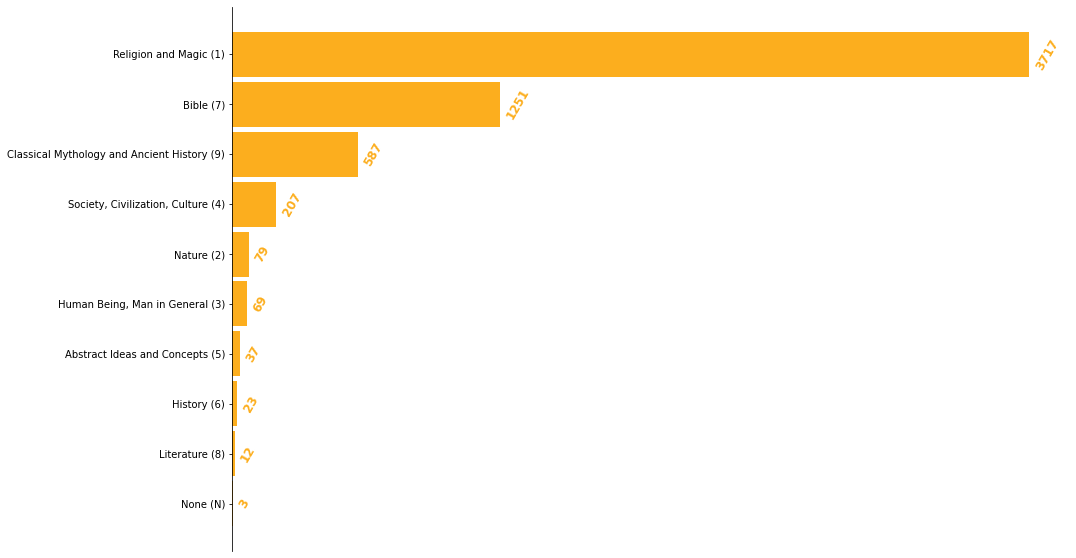

In [521]:
c_broad = Counter(hands_icon_broad) #count the occurences of each iconography
c_broad = c_broad.most_common()
[keys_, values_] = list(zip(*c_broad))
keys_names = [iconclass_dic_main[k]+" ({})".format(k) for k in keys_]

print_occurences_horizontal(keys_names, values_, "occurences_iconography_4th_hands_flipped.jpg")

No handles with labels found to put in legend.


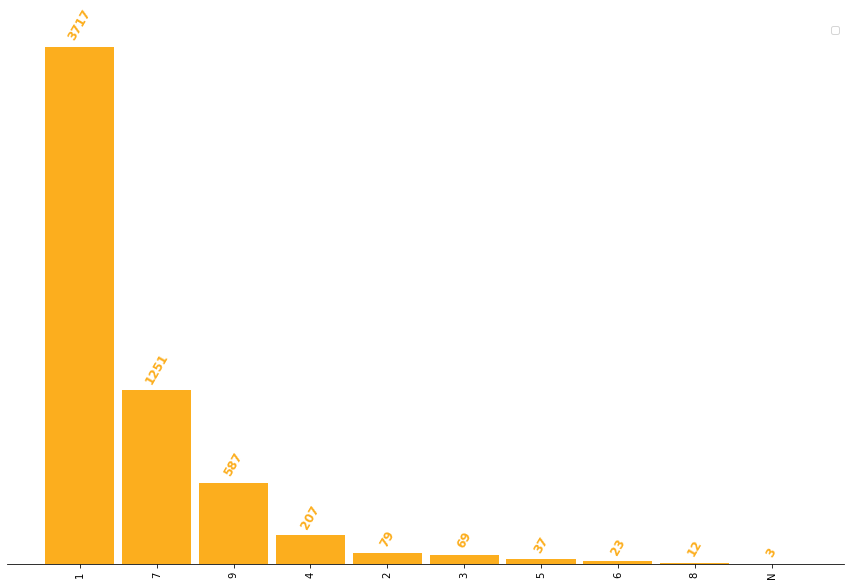

In [520]:
c_broad = Counter(hands_icon_broad) #count the occurences of each iconography
c_broad = c_broad.most_common()
[keys_, values_] = list(zip(*c_broad)) ### HERE YOU HAVE TO ADD A LEGEND WITH THE NAMES OF THE ICONOGRAPHIES

print_occurences(keys_, values_, "occurences_iconographies_4th_hands_flipped_main.jpg")

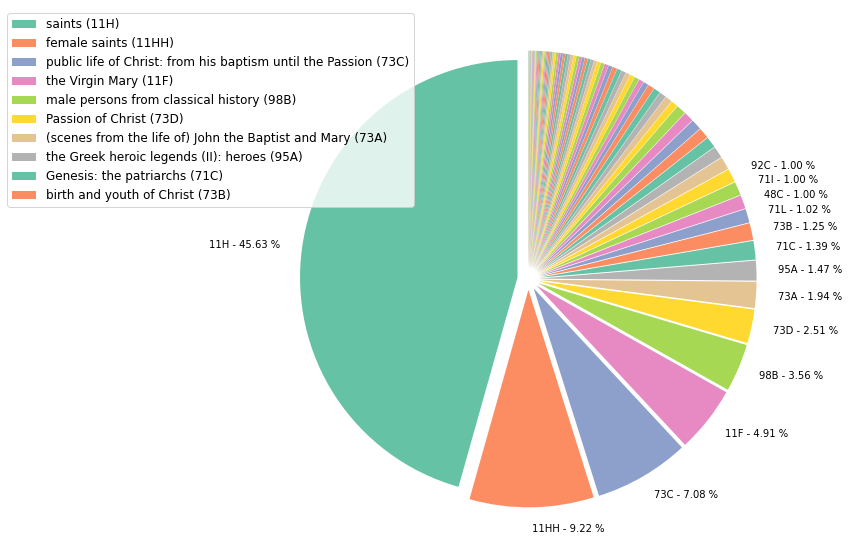

In [525]:
c = Counter(hands_icon) #count the occurences of each iconography
c = c.most_common()
[keys_, values_] = list(zip(*c))

keys_names = [iconclass_dic_4[k]+" ({})".format(k) if k != 'None' else "None" for k in keys_]

colors = ["#B9DDF1", '#4F6272', "#9FCAE6", '#DD7596', "#73A4CA", '#8EB897', "#497AA7", "#2E5B88"]
labels = ['{0} - {1:1.2f} %'.format(i, j) if j > 1.0 else '' for i, j in zip(keys_, 100*np.array(values_)/np.array(values_).sum())]

fig, ax = plt.subplots(figsize=(10, 10))
patches, text = ax.pie(values_, labels=labels, colors=sns.color_palette('Set2'),startangle=90, explode=[0.05]*len(values_))
ax.axes.get_yaxis().set_visible(False)
plt.legend(patches[:10], keys_names[:10], loc='upper right', prop = { "size": 12 },bbox_to_anchor=(.3, 1),fontsize=8)
plt.savefig("pie_chart_occurence_iconography_4th_all_flipped_hands.jpg", bbox_inches='tight')
plt.show()

In [17]:
df_hands_clusters_flipped.head(10)

,hands,cluster,iconography
0,bhim00037788_0_hand_right.jpg,26,11H
1,bh012186_0_hand_right.jpg,5,73E
2,bh013263_0_hand_right.jpg,36,11D
3,bhim00037212_1_hand_right.jpg,33,42D
4,bhim00037212_3_hand_right.jpg,24,42D
5,bhim00037212_7_hand_right.jpg,13,42D
6,bh012634_0_hand_right.jpg,25,11H
7,bhim00024287_0_hand_right.jpg,24,11H
8,bhim00017456_0_hand_right.jpg,8,11H
9,bh052628_3_hand_right.jpg,1,73C


In [18]:
#Here we get the hand combinations for each painting
hands_combination = {}

for i, row in df_hands_clusters_flipped.iterrows():
    img_digital =  row['hands'].split('_')[0]
    cluster = row['cluster']

    if img_digital in hands_combination:
        hands_combination[img_digital].append(cluster)
    else:
        hands_combination[img_digital] = [cluster]

#sort the combinations
for key, item in hands_combination.items():
    hands_combination[key] = sorted(item)

In [19]:
hands_combination

{'bhim00037788': [5, 26],
 'bh012186': [5],
 'bh013263': [35, 36],
 'bhim00037212': [2, 12, 13, 17, 24, 32, 33],
 'bh012634': [25],
 'bhim00024287': [24],
 'bhim00017456': [8],
 'bh052628': [1, 8],
 'bhim00033989': [12],
 'bh000775': [3, 3, 4],
 'bh013546': [9, 13, 31],
 'bh013200': [11, 14, 21, 24],
 'bh013091': [10, 13, 20, 28, 28],
 'bhim00037058': [4, 8, 12, 16, 21, 30, 35],
 'bh012280': [26, 26],
 'bh001533': [25],
 'bh002586': [15, 24, 25, 26, 30, 31],
 'bhim00038638': [17],
 'bh013276': [8],
 'bh209938': [5, 23, 37],
 'bhpd68259': [27, 33],
 'bhim00027728': [7, 15, 31],
 'bhim00017324': [8, 16, 16, 33],
 'bhim00037841': [11, 21, 21, 21, 22, 23],
 'bh012257': [21],
 'bh000889': [31, 35],
 'bhim00038652': [10, 33, 35],
 'bhped65793': [1, 37],
 'bh012233': [28, 29],
 'bhpeb70657': [1, 2, 10, 15, 35],
 'bh001987': [8, 8],
 'bhim00017466': [9, 17],
 'bhim00028070': [10, 11, 25],
 'bhim00033973': [6, 31, 31],
 'bh012093': [24],
 'bh001935': [1, 3],
 'bh000861': [1, 31, 33],
 'bh000450

In [81]:
#We then group the hand combinations according to iconography
from_ = []
to_ = []
icon_ = []

for key, combination in hands_combination.items():
    icon = df_hands_clusters_flipped.loc[df_hands_clusters_flipped['hands'].str.contains(key), 'iconography'].values[0]
    for idx, a in enumerate(combination):
        if len(combination) == 1:
            icon_.append(icon)
            from_.append(a)
            to_.append('None')
        else:
            for b in combination[idx + 1:]:
                icon_.append(icon)
                from_.append(a)
                to_.append(b)

In [82]:
df_combinations = pd.DataFrame({'iconography': icon_, 'from': from_, 'to': to_})

In [83]:
df_combinations

,iconography,from,to
0,11H,5,26
1,73E,5,None
2,11D,35,36
3,42D,2,12
4,42D,2,13
...,...,...,...
9242,11H,8,None
9243,11H,17,None
9244,48C,17,None
9245,11F,8,28


In [84]:
df_combinations_simple = pd.DataFrame({'from': from_, 'to': to_})

### Plot heatmap

In [86]:
counter_df_ = df_combinations_simple.groupby(df_combinations_simple.columns.tolist(), as_index=False, dropna=False).size()

In [75]:
counter_df_ = counter_df_.fillna('None')

In [87]:
heatmap_df_ = counter_df_.pivot_table(index='from', columns='to', values='size', fill_value=0, dropna=False)

In [88]:
heatmap_df_

to,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,36,37,38,39,None
from,,,,,,,,,,,,,,,,,,,,,
0,6,5,6,1,4,0,2,5,7,1,...,2,1,1,5,2,1,1,5,4,7
1,28,72,44,16,40,9,18,62,72,13,...,25,5,40,23,22,4,14,20,14,62
2,0,39,40,11,35,3,21,44,74,16,...,23,5,18,14,14,5,16,24,14,20
3,0,0,24,12,33,7,20,53,24,5,...,18,6,17,12,16,7,23,17,13,30
4,0,0,0,1,10,2,2,12,11,4,...,4,3,7,3,6,1,1,3,0,18
5,0,0,0,0,14,7,9,31,24,10,...,9,3,22,6,11,5,19,6,11,43
6,0,0,0,0,0,0,1,5,6,4,...,15,0,9,1,7,2,4,1,1,18
7,0,0,0,0,0,0,5,16,25,6,...,10,5,10,6,5,5,13,10,10,20
8,0,0,0,0,0,0,0,42,51,13,...,38,7,52,19,33,1,21,25,23,70


In [78]:
heatmap_df_.head(3)

to,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,None
from,,,,,,,,,,,,,,,,,,,,,
0,6,5,6,1,4,0,2,5,7,1,...,2,1,1,5,2,1,1,5,4,7
1,28,72,44,16,40,9,18,62,72,13,...,25,5,40,23,22,4,14,20,14,62
2,0,39,40,11,35,3,21,44,74,16,...,23,5,18,14,14,5,16,24,14,20


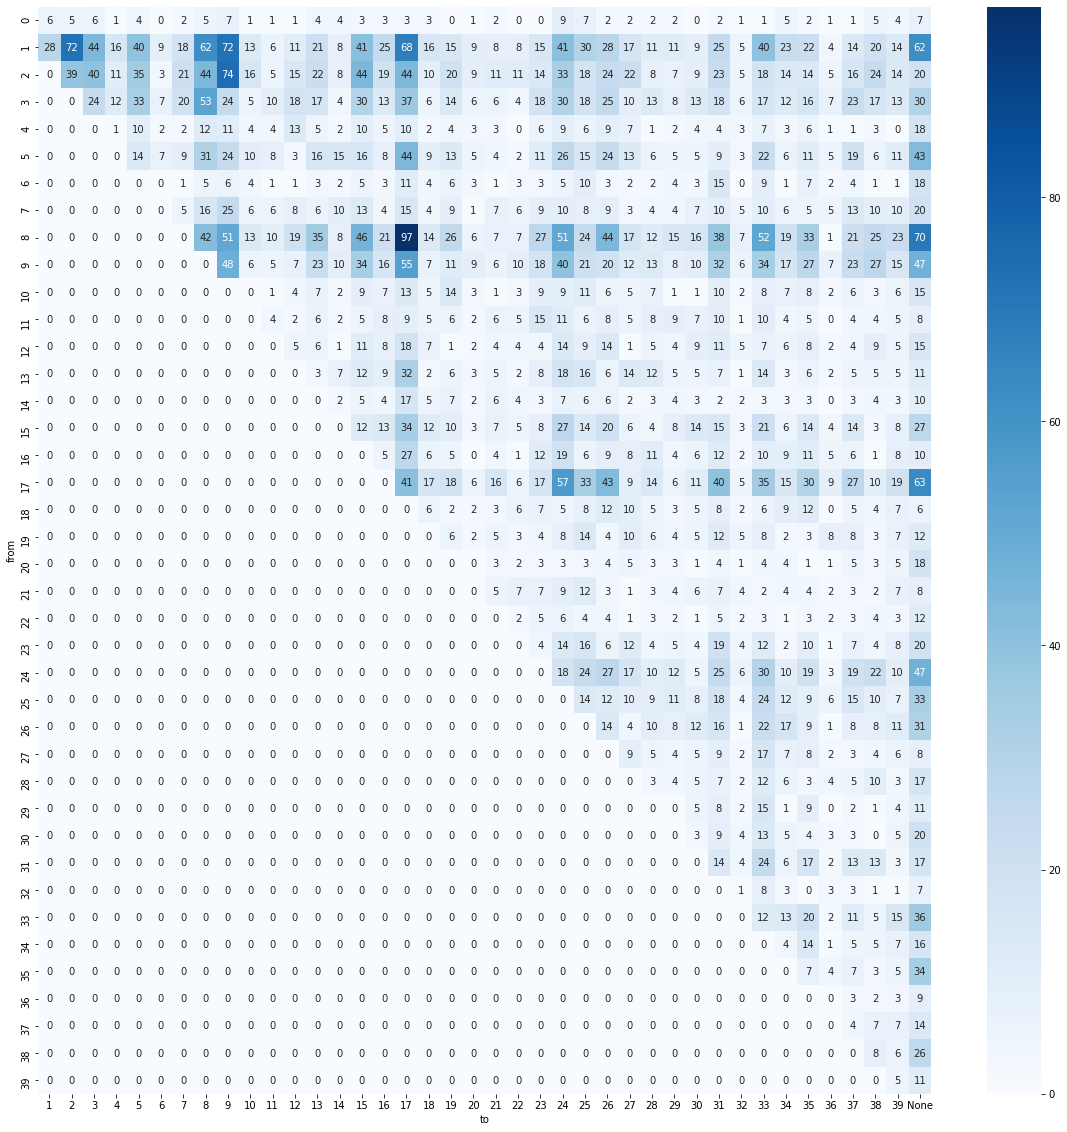

In [89]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(heatmap_df_, cmap="Blues", annot=True)
plt.savefig('hands_flipped_combination_heatmap_.png')

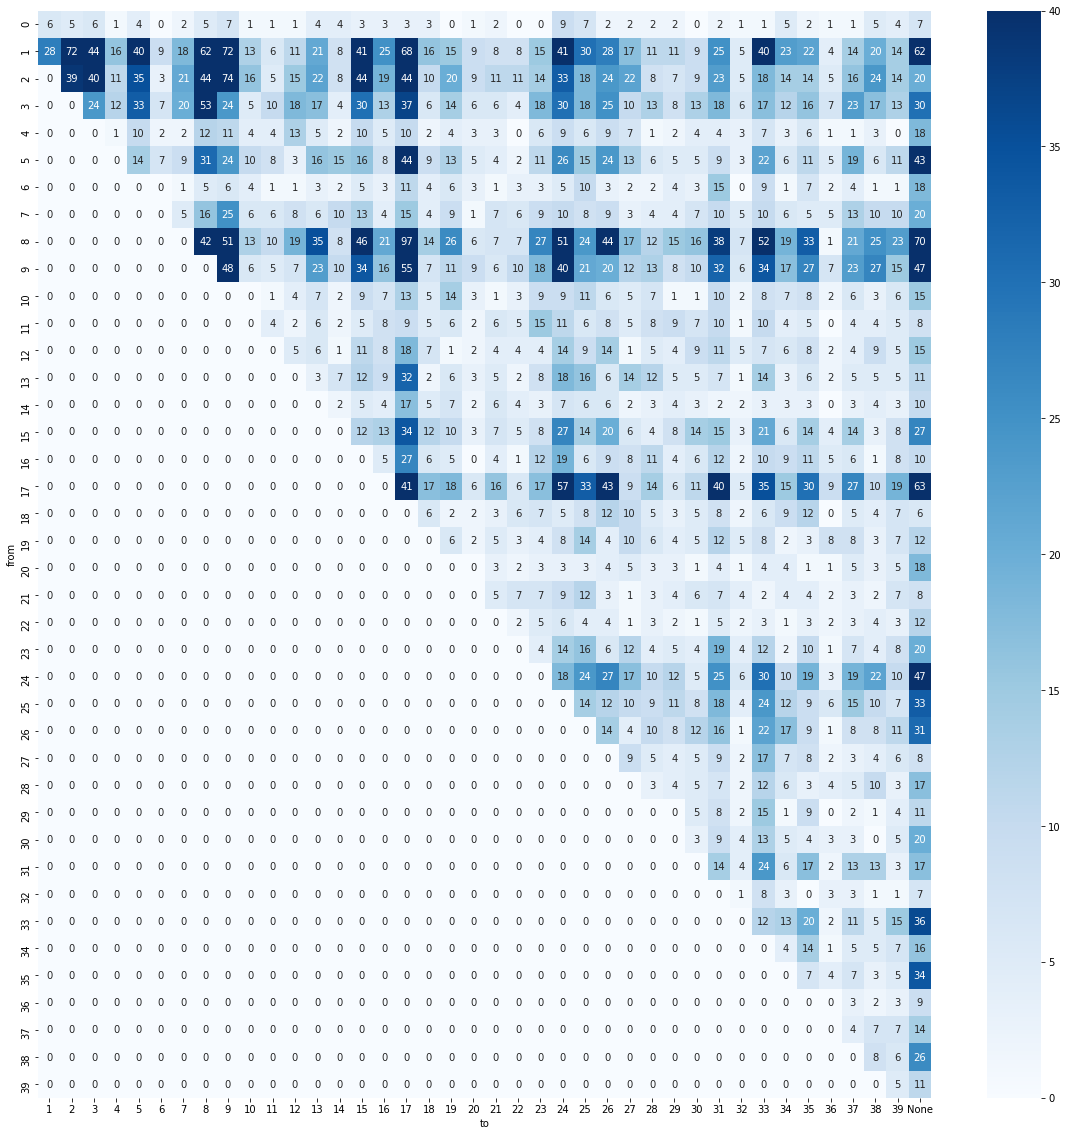

In [91]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(heatmap_df_, cmap="Blues", annot=True,robust=True)
plt.savefig('hands_flipped_combination_heatmap_robust_quantiles.png')

## TRASH 

In [258]:
words_list = ['Obst', '', 'Gemüse', 'Verkäufer']

final_keywords = []
keywords_count = []

lang = 'de'

for word in words_list:        
    word_keywords_count = [] ##V2
    #keywords = getKeyFromTitle_(word, lang)
    print(word)
    if word:
        keywords = getKeyFromTitle_(word, lang)
        print(keywords)
        print(len(keywords))
        for key_ in keywords:
            print(key_)
            short_key = key_[:3] #here we take the three first descriptors (i.e. 11F in 11F112)
            print(short_key)
            word_keywords_count.append(short_key)
            keywords_count.append(short_key)
            #keywords_count.append(short_key) ##V2
            #already do a Counter(keywords_).most_common() for each word and pick the most important out of the list
            #p.ex. ["11F4134","11F4136","11F4233","11F4231","11F4137","11F4232","11F413","11F4132","11F4135","11F43131","11F621","11F423","11F44","11F61","11F41121","11F43","11F41","11F4131","11F4133","11F62","11F611","11F612","11F6211","11F42","11F623","11F41231"]
            # return ("11F", 23) ("11H", 2) and from this you then just pick "11F"

#then here, you take your list for each words (Madonna-> "11F", heiligen -> "11h", ect...) and you count each occurence
# for each category. If two categories have same count, pick the FIRST ONE. 
final_keywords.append(get_tuple_count_list(keywords_count))#remove the most_common from here, instead, count the amount of time each category appear in the broad list and put priority on the first one

print("Keywords count", keywords_count)
print(final_keywords)

Obst
['41C653(...)', '41C6531', '41C653', '41C65', '41C652', '41C651', '47I4131', '41C6521', '41C652(...)', '47I4132', '41C6521(...)', '41C6511', '47I4', '47I41', '47I42', '47I413', '47I411', '47I412', '47I425', '47I421', '47I422', '47I424', '47I423', '47I4251', '47I4222', '47I426', '47I4223', '47I4221', '47I4241', '47I4231', '47I4242', '47I4211', '71O134', '47I42421', '91E21', '73C8171', '91E211']
37
41C653(...)
41C
41C6531
41C
41C653
41C
41C65
41C
41C652
41C
41C651
41C
47I4131
47I
41C6521
41C
41C652(...)
41C
47I4132
47I
41C6521(...)
41C
41C6511
41C
47I4
47I
47I41
47I
47I42
47I
47I413
47I
47I411
47I
47I412
47I
47I425
47I
47I421
47I
47I422
47I
47I424
47I
47I423
47I
47I4251
47I
47I4222
47I
47I426
47I
47I4223
47I
47I4221
47I
47I4241
47I
47I4231
47I
47I4242
47I
47I4211
47I
71O134
71O
47I42421
47I
91E21
91E
73C8171
73C
91E211
91E

Gemüse
['41C6521(...)', '41C6521', '41C652(...)', '41C652', '41C65', '41C653', '41C651', '41C653(...)', '41C6531', '41C6511', '47I3', '48AA9832', '41CC2611', '41